In [89]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score
import statsmodels.api as sm
from sklearn.feature_selection import SelectFromModel

from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import RFE

from xgboost import *
from hyperopt import hp

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, \
    f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Load data and clean

In [90]:
df = pd.read_csv('Layoff.csv',encoding='cp1252')
df = df.drop(['Company', 'City', 'State', 'Closure/Layoff','Temporary/Permanent', 'Effective Date','Union','Region','County'], axis=1)
df['WARN Received Date'] = pd.to_datetime(df['WARN Received Date'])
df['by_month'] = df['WARN Received Date'].dt.strftime("%Y-%m")
df = df.drop(['WARN Received Date'], axis=1)
df = df[(df.by_month<'2020-03')|(df.by_month>'2021-09')].copy()
# Check for missing values
df.isna().sum()
df.head()

,Number of Workers,Industry,Open,High,Low,Close,Volume,CPI,PPI,GDP,...,Date,Hire_quite_jolts,Job_seekers_ratio,hires_sm,quits_sm,layoffs_sm,actual_hire,log_num_of_workers,layoff_category_by_log,layoff_category_by_num
0,489.0,Consumer Discretionary Select Sector SPDR Fund,123.1900,124.33000,121.18000,121.49000,12360390.0,2.334874,196.7,1.6,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,6.192362,3,3
1,96.0,Consumer Discretionary Select Sector SPDR Fund,27.4344,27.71252,26.96252,27.22188,124920.0,2.334874,196.7,1.6,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,4.564348,3,2
2,95.0,Consumer Discretionary Select Sector SPDR Fund,27.4344,27.71252,26.96252,27.22188,124920.0,2.334874,196.7,1.6,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,4.553877,3,2
3,87.0,Consumer Discretionary Select Sector SPDR Fund,27.4344,27.71252,26.96252,27.22188,124920.0,2.334874,196.7,1.6,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,4.465908,3,2
4,75.0,Consumer Discretionary Select Sector SPDR Fund,27.4344,27.71252,26.96252,27.22188,124920.0,2.334874,196.7,1.6,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,4.317488,3,2


In [91]:
df.dtypes

Number of Workers         float64
Industry                   object
Open                      float64
High                      float64
Low                       float64
Close                     float64
Volume                    float64
CPI                       float64
PPI                       float64
GDP                       float64
unemployment_rate         float64
job_nonfam                  int64
job_IT                      int64
job_service                 int64
job_retail                  int64
job_education_health        int64
fed_rate                  float64
PPI_chg                   float64
PPI_CPI                   float64
by_month                   object
Date                       object
Hire_quite_jolts          float64
Job_seekers_ratio         float64
hires_sm                  float64
quits_sm                  float64
layoffs_sm                float64
actual_hire               float64
log_num_of_workers        float64
layoff_category_by_log      int64
layoff_categor

In [92]:
quantiles = df['Number of Workers'].quantile([0.25, 0.5, 0.75])
quantiles

0.25     15.0
0.50     52.0
0.75    100.0
Name: Number of Workers, dtype: float64

In [93]:
df['layoff_category_quantile'] = pd.cut(df['Number of Workers'], bins=[0, quantiles.iloc[0], quantiles.iloc[1], df['Number of Workers'].max()], labels=[1,2,3])

# Exploratory Data Analysis

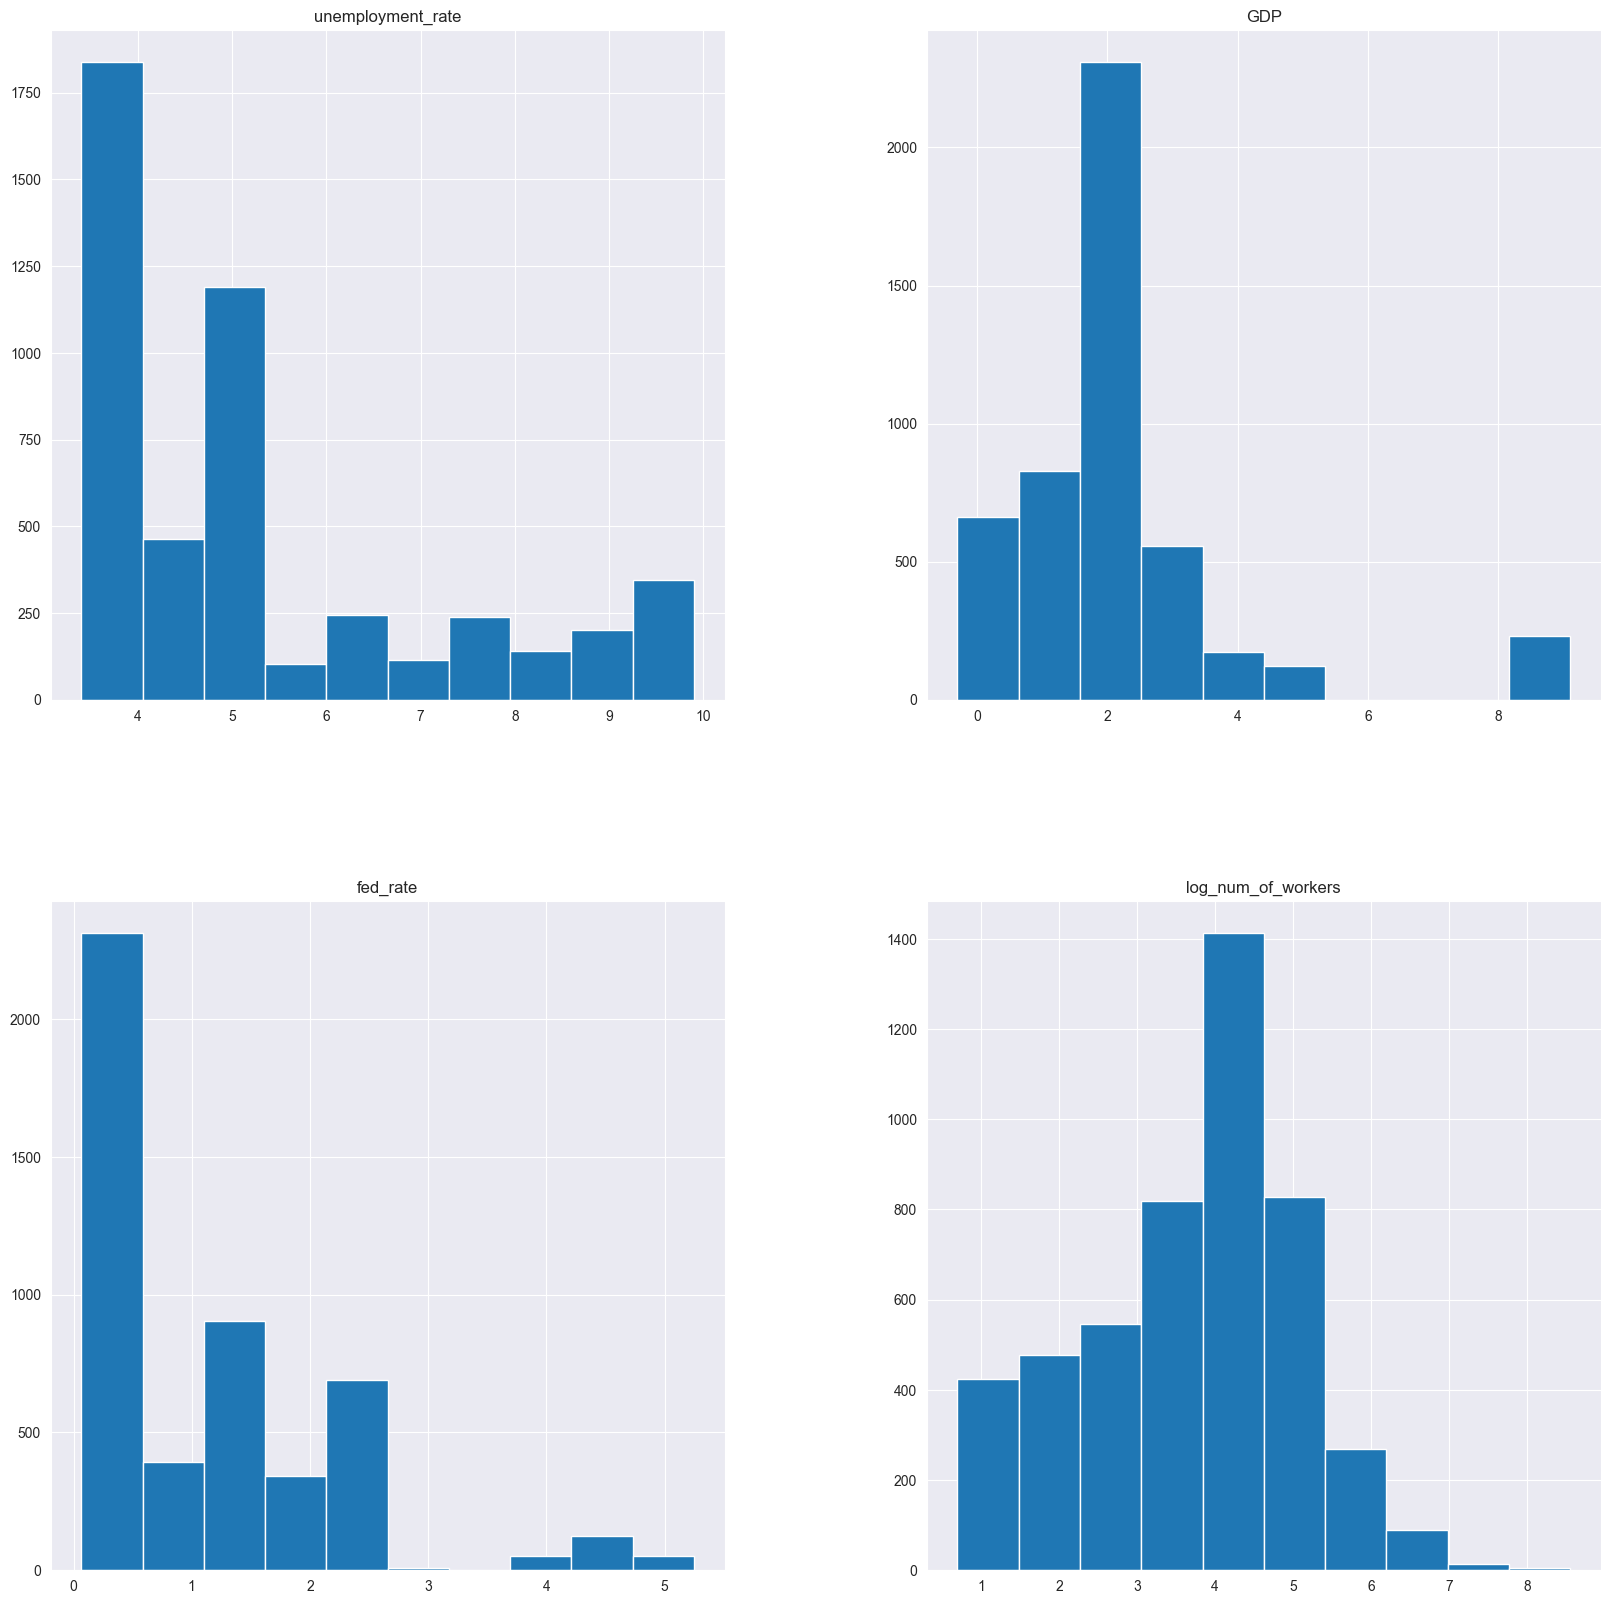

In [94]:
df2 = df[['unemployment_rate', 'GDP', 'fed_rate', 'log_num_of_workers']]
df2.hist(figsize=(20,20))
plt.savefig('plots/histogram.pdf')

In [96]:
#fig, ax = plt.subplots(figsize=(15,15))
#sns.heatmap(df.corr(), annot=True, ax=ax)

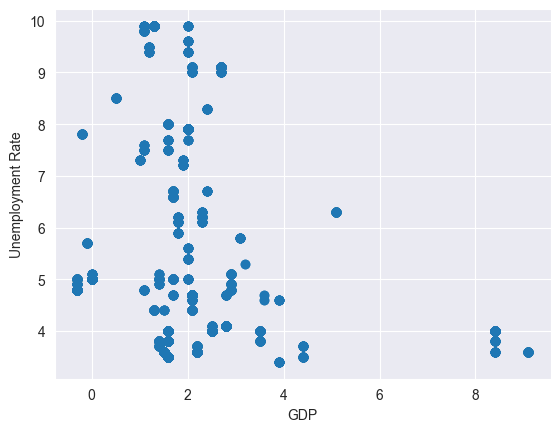

In [97]:
# Visualize the relationship between two numerical columns using a scatter plot
#plt.scatter(df['GDP'], df['unemployment_rate'])
#plt.xlabel('GDP')
#plt.ylabel('Unemployment Rate')
#plt.savefig('plots/GDP_unemployment.pdf')

In [99]:
#sortedDF = df.sort_values(by=['WARN Received Date'], ascending=True)
#fig, ax = plt.subplots(figsize=(10, 10))
 
#plt.plot(sortedDF['WARN Received Date'], sortedDF['Number of Workers'])
#plt.xlabel('Layoff Date')
#plt.ylabel('# of Employees affected')
#plt.show()

KeyError: 'WARN Received Date'

# Feature Engineering


In [103]:
df['Price Volatility'] = df['High'] - df['Low']
df['total_layoff'] = df.groupby(['by_month'])['Number of Workers'].transform(sum)

In [104]:
df_col = [#'State', 'Company', 'City', 'Number of Workers', 'WARN Received Date','Effective Date', 'Closure/Layoff', 'Temporary/Permanent', 'Union','by_month', 'Date','Region', 'County',
       'Industry', 'Open', 'High', 'Low', 'Close',
       'Volume', 'CPI', 'PPI', 'GDP', 'unemployment_rate', 'job_nonfam',
       'job_IT', 'job_service', 'job_retail', 'job_education_health',
       'fed_rate', 'PPI_chg', 'PPI_CPI',
       'Hire_quite_jolts', 'Job_seekers_ratio', 'hires_sm', 'quits_sm',
       'layoffs_sm', 'actual_hire',
       'layoff_category_by_log', 'layoff_category_by_num' ]
df = df[df_col].copy()

In [105]:
le = preprocessing.LabelEncoder()
df['Industry']=le.fit_transform(df['Industry'])
df['Industry'] = df['Industry'].astype('category')

# ML Models

In [106]:
X = df.iloc[:,:-2]
y = df.iloc[:,-1]

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=77, stratify=df['layoff_category_by_num'])
model_name = []
acc = []
precision = []
f1 = []
recall = []


acc_t = []
precision_t = []
f1_t = []
recall_t = []

# Random Forest

In [108]:
# define the method
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
# fit the model
rfe.fit(X, y)


In [109]:
rfe.get_feature_names_out()

In [110]:
rf_sector = []
rf_model = []
rf_best_param = []
rf_acc = []
rf_fi = []


randomforestCLF = RandomForestClassifier(criterion = 'gini' , n_jobs = -1)

parameters_rf = {'n_estimators':[10 , 100 , 250, 500, 600,700,1000 ],
                 'max_depth' : [ None , 4 , 8  , 10 , 12] ,
                 'max_features' : ['sqrt' , 'log2'] ,
                 'max_leaf_nodes' : [2 , 4 , 8 , 10] ,
                 'max_samples' : [50 , 100 , 150,300]}

'''cross validation'''
rf_rand_cv = RandomizedSearchCV(randomforestCLF , parameters_rf , cv = 5 ,scoring='accuracy', n_jobs = -1 ,error_score='raise')
rf_rand_cv.fit(X_train[rfe.get_feature_names_out()], y_train)

rf_best_param.append(rf_rand_cv.best_params_)

randomforestCLF = RandomForestClassifier(n_estimators = rf_rand_cv.best_params_['n_estimators'] ,
                                                                max_depth = rf_rand_cv.best_params_['max_depth'],
                                                                max_features = rf_rand_cv.best_params_['max_features'],
                                                                max_leaf_nodes = rf_rand_cv.best_params_['max_leaf_nodes'],
                                                                max_samples = rf_rand_cv.best_params_['max_samples'],
                                                                n_jobs = -1)
randomforestCLF.fit(X_train[rfe.get_feature_names_out()], y_train)


In [111]:
def output_score(train,pred):
    return accuracy_score(train, pred), f1_score(train, pred,average='macro'), recall_score(train, pred,average='macro'),precision_score(train, pred,average='macro',zero_division=0)

In [112]:
y_pred = randomforestCLF.predict(X_train[rfe.get_feature_names_out()])
print("Train_pred_acc:" + str(accuracy_score(y_train, y_pred)))
print("Train_pred_f1:" + str(f1_score(y_train, y_pred,average='macro')))
print("Train_pred_recall:" + str(recall_score(y_train, y_pred,average='macro')))
print("Train_pred_precision:" + str(precision_score(y_train, y_pred,average='macro',zero_division=0)))

rf_acc, rf_f1, rf_recall, rf_pre = output_score(y_train,y_pred)



In [113]:
model_name.append('RF')
acc.append(rf_acc)
precision.append(rf_pre)
f1.append(rf_f1)
recall.append(rf_recall)

In [114]:

y_pred_test = randomforestCLF.predict(X_test[rfe.get_feature_names_out()])
rf_acc, rf_f1, rf_recall, rf_pre = output_score(y_test,y_pred_test)



acc_t.append(rf_acc)
precision_t.append(rf_pre)
f1_t.append(rf_f1)
recall_t.append(rf_recall)


# Gradient Boost

In [115]:
rfe_gb = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=10)
# fit the model
rfe_gb.fit(X, y)

In [116]:
rfe_gb.get_feature_names_out()

In [117]:
gradientB_clf = Pipeline(steps = [('scaler' , StandardScaler()) ,
                                  ('gb' , GradientBoostingClassifier())])

parameters_gb = { 'gb__learning_rate' : [0.01 , 0.001 , 0.1 , 0.5 , 1] ,
                 'gb__n_estimators' : [100 , 200 , 300 , 400 , 500 , 750] ,
                 'gb__subsample' : [0.5 , 0.1 , 1.0] ,
                 'gb__criterion' : ['friedman_mse'] ,
                 'gb__max_depth' : [1 , 2 , 5 , 7 , 10 , 15] ,
                 'gb__max_features' : ['sqrt' , 'log2' , 2 , 5] ,
                 'gb__max_leaf_nodes' : [None , 2 , 3 , 5 , 6 , 7 , 8 , 9 , 10]}

gb_clf_randCV = RandomizedSearchCV(gradientB_clf , parameters_gb, n_iter=50, scoring='accuracy' , n_jobs = -1)
gb_clf_randCV.fit(X_train[rfe_gb.get_feature_names_out()] , y_train)

In [118]:
gb_clf_randCV.best_params_

In [119]:
gradientB_clf = GradientBoostingClassifier(learning_rate = gb_clf_randCV.best_params_['gb__learning_rate'],
                                                                     max_depth = gb_clf_randCV.best_params_['gb__max_depth'],
                                                                     max_features = gb_clf_randCV.best_params_['gb__max_features'],
                                                                     max_leaf_nodes = gb_clf_randCV.best_params_['gb__max_leaf_nodes'],
                                                                     n_estimators = gb_clf_randCV.best_params_['gb__n_estimators'],random_state=13)

gradientB_clf.fit(X_train[rfe_gb.get_feature_names_out()], y_train)

In [120]:

y_pred = gradientB_clf.predict(X_train[rfe_gb.get_feature_names_out()])
print("Train_pred:" + str(accuracy_score(y_train, y_pred)))


gb_acc, gb_f1, gb_recall, gb_pre = output_score(y_train,y_pred)


model_name.append('gb')
acc.append(gb_acc)
precision.append(gb_pre)
f1.append(gb_f1)
recall.append(gb_recall)


In [121]:

y_pred_test = gradientB_clf.predict(X_test[rfe_gb.get_feature_names_out()])
print("Test_pred:" + str(accuracy_score(y_test, y_pred_test)))

gb_acc, gb_f1, gb_recall, gb_pre = output_score(y_test,y_pred_test)



acc_t.append(gb_acc)
precision_t.append(gb_pre)
f1_t.append(gb_f1)
recall_t.append(gb_recall)


print(gradientB_clf.feature_importances_)

# xGBoost

In [122]:
rfe_xgb = RFE(estimator=XGBClassifier(), n_features_to_select=10)
# fit the model
rfe_xgb.fit(X, y-1)

In [123]:
from scipy import stats

param_grid = {
    'learning_rate': [0.2, 0.1],
    'num_leaves': [25, 35],
    'max_depth': [10, 12]
}

param_dist = {
    'learning_rate': stats.uniform(0.09, 0.25),
    'num_leaves': stats.randint(20,40),
    'max_depth': [10, 12]
}

param_dist_hyperopt = {
    'max_depth': 15 + hp.randint('num_leaves', 5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

clf_xgb = XGBClassifier(n_estimators=150, tree_method="approx", enable_categorical=True, random_state=0, verbosity=0, n_jobs=-1)

In [124]:
# Use Shap hypertune to find xgb param

model = BoostSearch(clf_xgb, param_grid=param_grid)
model.fit(X_train[rfe_xgb.get_feature_names_out()], y_train-1, eval_set=[(X_test[rfe_xgb.get_feature_names_out()], y_test-1)], verbose=0)

In [125]:
model.estimator_, model.best_params_, model.best_score_

In [126]:
model.score(X_test[rfe_xgb.get_feature_names_out()], y_test-1)

In [127]:
xgb_best = XGBClassifier(n_estimators=150, tree_method="approx",
                         learning_rate = model.best_params_['learning_rate'],
                         num_leaves = model.best_params_['num_leaves'],
                         max_depth = model.best_params_['max_depth'],
                         enable_categorical=True, random_state=0, verbosity=0, n_jobs=-1)

xgb_best.fit(X_train[rfe_xgb.get_feature_names_out()],y_train-1)


In [128]:

pred = xgb_best.predict(X_train[rfe_xgb.get_feature_names_out()])

xgb_acc, xgb_f1, xgb_recall, xgb_pre = output_score(y_train-1,pred)



In [129]:
model_name.append('xgb')

acc.append(xgb_acc)
precision.append(xgb_pre)
f1.append(xgb_f1)
recall.append(xgb_recall)

In [130]:

pred = xgb_best.predict(X_test[rfe_xgb.get_feature_names_out()])

xgb_acc, xgb_f1, xgb_recall, xgb_pre = output_score(y_test-1,pred)


acc_t.append(xgb_acc)
precision_t.append(xgb_pre)
f1_t.append(xgb_f1)
recall_t.append(xgb_recall)

In [131]:
xgb_best.feature_importances_

## GaussianNB

In [132]:
gnb = GaussianNB()

In [133]:
pred = gnb.fit(X_train, y_train).predict(X_train)
gnb_acc, gnb_f1, gnb_recall, gnb_pre = output_score(y_train-1,pred)
model_name.append('gnb')

acc.append(gnb_acc)
precision.append(gnb_pre)
f1.append(gnb_f1)
recall.append(gnb_recall)

pred = gnb.fit(X_train, y_train).predict(X_test)

gnb_acc, gnb_f1, gnb_recall, gnb_pre = output_score(y_test-1,pred)


acc_t.append(gnb_acc)
precision_t.append(gnb_pre)
f1_t.append(gnb_f1)
recall_t.append(gnb_recall)

## Random forest

## Extra Trees Classifier

In [134]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

pred = etc.fit(X_train, y_train).predict(X_train)
etc_acc, etc_f1, etc_recall, etc_pre = output_score(y_train-1,pred)
model_name.append('etc')

acc.append(etc_acc)
precision.append(etc_pre)
f1.append(etc_f1)
recall.append(etc_recall)

pred = etc.fit(X_train, y_train).predict(X_test)

etc_acc, etc_f1, etc_recall, etc_pre = output_score(y_test-1,pred)


acc_t.append(etc_acc)
precision_t.append(etc_pre)
f1_t.append(etc_f1)
recall_t.append(etc_recall)

## SGD

In [135]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, alpha=1, penalty='l1'))
preds = clf.fit(X_train, y_train).predict(X_test)

In [136]:
param_grid = {'alpha' : [.001,.01,.1,1,10,100],
              'penalty': ['l2', 'l1', 'elasticnet', None]}

gridsearch = GridSearchCV(SGDClassifier(max_iter=1000, tol=1e-3), param_grid, cv=10).fit(X_train, y_train)

In [137]:
gridsearch.best_params_

In [138]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, alpha=gridsearch.best_params_['alpha'], penalty=gridsearch.best_params_['penalty']))

In [139]:
pred = clf.fit(X_train, y_train).predict(X_train)
clf_acc, clf_f1, clf_recall, clf_pre = output_score(y_train-1,pred)
model_name.append('clf')

acc.append(clf_acc)
precision.append(clf_pre)
f1.append(clf_f1)
recall.append(clf_recall)

pred = clf.fit(X_train, y_train).predict(X_test)

clf_acc, clf_f1, clf_recall, clf_pre = output_score(y_test-1,pred)


acc_t.append(clf_acc)
precision_t.append(clf_pre)
f1_t.append(clf_f1)
recall_t.append(clf_recall)

# Feature Selection

In [140]:
#model0 = SelectFromModel(clf, prefit=True)

In [141]:
#X_train_new = model0.transform(X_train)

In [142]:
#feature_names = X_train.columns[model0.get_support()]

In [143]:
#print('Feature Names \n',feature_names)

In [144]:
#X_test_new = X_test[feature_names]

In [145]:
#X_test_new = X_test[['Open','GDP','unemployment_rate', 'year', 'Hires_jolts',
#       'Layoffs_jolts', 'Hire_quite_jolts', 'Job_seekers_ratio', 'Industry_Consumer Discretionary Select Sector SPDR Fund', 'Industry_Energy Select Sector SPDR Fund','Industry_Financial Select Sector SPDR Fund','Industry_Industrial Select Sector SPDR Fund','Industry_Materials Select Sector SPDR Fund','Industry_Utilities Select Sector SPDR Fund']]

In [146]:
#MLR0 = LinearRegression().fit(X_train_new, y_train)
#preds = MLR0.predict(X_test_new)

In [147]:
#preds = np.round(preds)

In [148]:
#y_test = y_test.cat.codes.astype(np.float64)

In [149]:
#accuracy_score(preds,y_test)

# Kernel SVM

In [150]:
svm = SVC(kernel="rbf")


pred = svm.fit(X_train, y_train).predict(X_train)
svm_acc, svm_f1, svm_recall, svm_pre = output_score(y_train-1,pred)
model_name.append('svm')

acc.append(svm_acc)
precision.append(svm_pre)
f1.append(svm_f1)
recall.append(svm_recall)

pred = svm.fit(X_train, y_train).predict(X_test)

svm_acc, svm_f1, svm_recall, svm_pre = output_score(y_test-1,pred)


acc_t.append(svm_acc)
precision_t.append(svm_pre)
f1_t.append(svm_f1)
recall_t.append(svm_recall)



# Neural Net

In [151]:
nn = MLPClassifier(alpha=1, hidden_layer_sizes = (20, 10))

pred = nn.fit(X_train, y_train).predict(X_train)
nn_acc, nn_f1, nn_recall, nn_pre = output_score(y_train-1,pred)
model_name.append('nn')

acc.append(nn_acc)
precision.append(nn_pre)
f1.append(nn_f1)
recall.append(nn_recall)

pred = nn.fit(X_train, y_train).predict(X_test)

nn_acc, nn_f1, nn_recall, nn_pre = output_score(y_test-1,pred)


acc_t.append(nn_acc)
precision_t.append(nn_pre)
f1_t.append(nn_f1)
recall_t.append(nn_recall)



In [156]:
df_train = pd.DataFrame(data={'accuracy':acc,
                              'precision': precision,
                              'F1': f1,
                              'recall': recall},
                        index=model_name)

print(df_train)

In [154]:
df_test = pd.DataFrame(data={'accuracy':acc_t,
                              'precision': precision_t,
                              'F1': f1_t,
                              'recall': recall_t},
                        index=model_name)

df_test